In [5]:
import numpy as np
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt
from fishtrack.measurements import tail_angle
from fish.image.vol import dff
import peakutils as pk
from skimage.exposure import adjust_gamma
from scipy.ndimage.filters import median_filter, gaussian_filter
import pims

from pathlib import Path
from os.path import sep,split
from collections import OrderedDict

%matplotlib inline

In [2]:
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

In [3]:
import pyqtgraph as pq
%gui qt

In [9]:
exps = OrderedDict()

fs_im = 100
base_dir = '/groups/ahrens/ahrenslab/davis/data/epi/20170621/'

exp_dirs = list(Path(base_dir).iterdir())
exp_dirs.sort()

for expd in exp_dirs:
    exp_name = expd.parts[-1]
    raw_im_dir = expd / 'Pos0'
    aligned_fname = expd / (exp_name + '_aligned.tif')
    # we only work with experiments where the aligned images are saved
    if aligned_fname.exists():
        pos_params_fname = expd / (exp_name + '_position_data.npz')
        affine_params_fname = expd / 'regparams.npy'
        exps[exp_name] = {'raw_dir' : raw_im_dir, 
                          'aligned' : aligned_fname, 
                          'pos_params' : pos_params_fname, 
                          'affine_params_fname' : affine_params_fname}
exp_names = list(exps.keys())

In [7]:
%%time
raw_ims = []
aligned_ims = []
for k in exps.keys():
    aligned_ims.append(pims.open(str(exps[k]['aligned'])))
    raw_ims.append(pims.ImageSequence(sorted(exps[k]['raw_dir'].glob('*.tif'))))

CPU times: user 1min 30s, sys: 2.91 s, total: 1min 32s
Wall time: 1min 36s


In [ ]:
exp = 5
pqim = pq.image(np.array(aligned_ims[exp]), title=exp_names[exp])

In [170]:
# when, frames, does the fish image stabilize
fish_onsets = [5890,1060,5740,1780,0,0,1200,0]

In [10]:
def tail_angle_wrapper(image, **kwargs):
    import fishtrack.measurements as meas
    return meas.tail_angle(np.array(image), **kwargs)

def get_events(data, thr_scale, duration):
    from fish.ephys.ephys import estimate_onset    
    thr = thr_scale * data.std() + np.median(data)
    events = estimate_onset(data, thr, duration=duration)
    
    return events

In [11]:
%%time
tail_angles = [tail_angle_wrapper(im, center=(100,200), radius=110) for im in aligned_ims]

CPU times: user 1min 48s, sys: 3min 17s, total: 5min 5s
Wall time: 5min 18s


In [ ]:
# load some masks
from scipy.sparse import load_npz
mask_fnames = sorted(glob('/groups/ahrens/ahrenslab/davis/data/epi/201'))
masks = [load_npz(f) for f in 

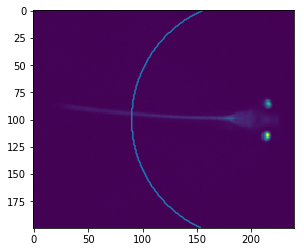

In [12]:
ind = 5
plt.imshow(aligned_ims[ind][-1])
plt.plot(*tail_angles[ind][1]);

In [13]:
%%time
# get rois means
from fishtrack.util import long_tail_threshold
roi_means = []
# pick an ROI that's ~50% fish
roi = (slice(90,108), slice(170,194))   
for im in aligned_ims:
    roi_means.append(np.array([im_[roi][im_[roi] > np.median(im_[roi])].mean() for im_ in im]))

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 1min 5s, sys: 58.1 s, total: 2min 3s
Wall time: 2min 3s


In [14]:
# make filtered baseline-normalized timeseries
smoothed_rois = []
from scipy.ndimage.filters import median_filter
for ind, val in enumerate(roi_means):
    dff_ = dff(median_filter(val[fish_onsets[ind]:],size=10), window=2000, percentile=10, baseline_offset=.01, downsample=8)
    # make a decaying exponential kernel
    kw = 2000
    tau  = 50
    kern = np.exp(-np.arange(kw)/tau)
    kern = np.concatenate([np.zeros(kern.shape), kern])
    kern /= kern.sum()

    from scipy.signal import convolve
    smoothed_rois.append(convolve(dff_ - dff_.mean(), kern, mode='same') + dff_.mean())


NameError: name 'fish_onsets' is not defined

In [ ]:
# Make smoothed tail power timeseries
smoothed_tail_power = []
for ind, val in enumerate(tail_angles):    
    from scipy.signal import convolve
    from numpy import diff
    #kw = 2000
    #tau  = 50
    #kern = np.exp(-np.arange(kw)/tau)
    #kern = np.concatenate([np.zeros(kern.shape), kern])
    #kern /= kern.sum()
    
    vel = np.abs(diff(val[0][fish_onsets[ind]:]))
    
    #smoothed_tail_power.append(convolve(sq_vel, kern,mode='same'))
    smoothed_tail_power.append(vel)

In [ ]:
# get threshold crossing events
events = []
peaks_fl =[]
peaks_pow = []
window_fl = np.arange(-200, 1000)
offset_fl = np.where(window_fl == 0)[0]
window_pow = np.arange(-1000, 1000)
offset_pow = np.where(window_pow == 0)[0]
for ind, val in enumerate(smoothed_rois):
    events.append(get_events(val, 2, 500))
    tmp_fl = []
    tmp_pow = []
    for ev in events[ind]:
        snip_fl = val[ev + window_fl]
        snip_pow = smoothed_tail_power[ind][ev + window_pow]
        tmp_pow.append((snip_pow.max(), np.argmax(snip_pow) - offset_pow))
        tmp_fl.append((snip_fl.max(), np.argmax(snip_fl)- offset_fl))
    peaks_fl.append(tmp_fl)
    peaks_pow.append(tmp_pow)

In [ ]:
fig, axs = plt.subplots(nrows=len(events), figsize=(16,8), sharex=True, sharey=True)
window_post = np.arange(0, 1000)
window_pre = np.arange(-1000,0)
for ind, ax in enumerate(axs):
    ax.plot(smoothed_rois[ind],'g')
    ax.annotate(exp_names[ind], (.5,.5), xycoords='axes fraction')
    ax.twinx().plot(smoothed_tail_power[ind], alpha=.4)
    [ax.axvline(e) for e in events[ind]]

In [438]:
cur_fish = 0
tmp = aligned_ims[cur_fish][fish_onsets[cur_fish]:]
pq.image(np.array(tmp), title=list(exps.keys())[cur_fish])

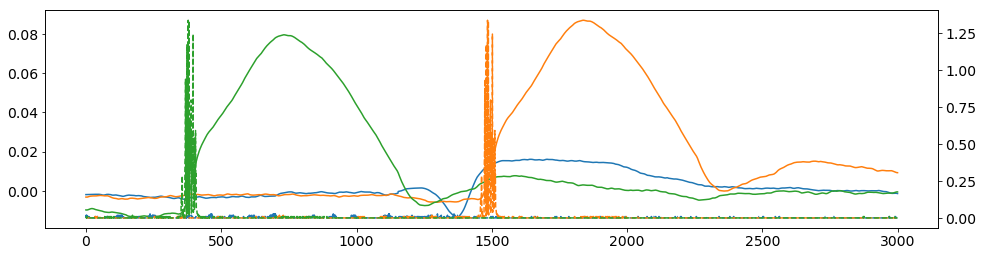

In [376]:
ind = 4
fig, axs = plt.subplots(figsize=(16,4))
axs.plot(trials['fl'][ind].T)
axs.twinx().plot(trials['tail'][ind].T,linestyle='--')

(-0.027488625012204643,
 0.3801285087688423,
 -0.032118749154719309,
 0.37549838462632762)

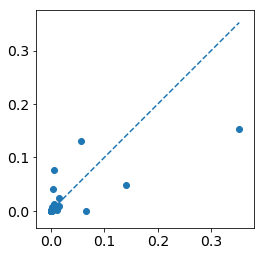

In [377]:
cur_fish = 0
all_tail = np.concatenate(trials['tail'])
post = all_tail[:,1500:1600].mean(1)
pre = all_tail[:,1400:1500].mean(1)
plt.scatter(pre, post)
lower_corner = min(pre.min(), post.min())
upper_corner = max(pre.max(), post.max())
plt.plot([lower_corner, upper_corner], [lower_corner, upper_corner], linestyle='--')
plt.axis('square')
#plt.ylim(lower_corner - (lower_corner * .5), upper_corner + (upper_corner * .5))
#plt.xlim(lower_corner, upper_corner)

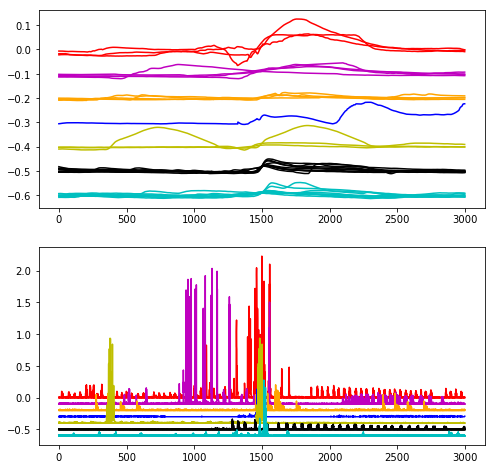

In [14]:
from scipy.stats import zscore
fig, axs = plt.subplots(figsize=(8,8), nrows=2)
window = np.arange(-1500,1500)

colors =['r','m','orange','b','y','k','c']
trials = {}
trials['fl'] = []
trials['tail'] = []

for ind, e in enumerate(events):
    trials['fl'].append(np.array([(smoothed_rois[ind][window + e_]) - np.median(smoothed_rois[ind][window + e_]) for e_ in e if (e_ + window[-1]) < len(smoothed_rois[ind])]))
    trials['tail'].append(np.array([smoothed_tail_power[ind][window + e_] for e_ in e if (e_ + window[-1]) < len(smoothed_rois[ind])]))

for ind, e in enumerate(events):
    [axs[0].plot(-ind * .1 + (smoothed_rois[ind][window + e_]) - np.median(smoothed_rois[ind][window + e_]), color=colors[ind]) for e_ in e if (e_ + window[-1]) < len(smoothed_rois[ind])]
    #[axs[0].plot(ind * 0 + (zscore(roi_means[ind][window + e_ + fish_onsets[ind]])), color='g') for e_ in e]
    [axs[1].plot(-ind * .1 + (smoothed_tail_power[ind][window + e_]), color=colors[ind]) for e_ in e if (e_ + window[-1]) < len(smoothed_rois[ind])]

In [18]:
ind = 1
import fish.ephys.ephys as ep
from scipy.ndimage.filters import percentile_filter
signal = dff(roi_means[ind][plr], window=2000, downsample=8, baseline_offset=0, percentile=10)
signal = gaussian_filter(signal, sigma=100)
thr = 3 * signal.std() + np.median(signal)
fig, axs = plt.subplots(figsize=(16,3))
axs.plot(signal)
axs.axhline(thr)
events = ep.estimate_onset(signal, thr, duration=1500)
events = events[events > 10]
[axs.axvline(e, zorder=0, color='k') for e in events];

event_ind = 1
window = np.arange(-2000,2000)
fig, axs = plt.subplots(nrows=len(events), figsize=(9,3))
if len(events) ==1:
    axs=[axs]
for ind_e, ax in enumerate(axs):
    ax.plot(window, tail_angles[ind][0][plr][window + events[ind_e]])
    ax_2 = ax.twinx()
    ax_2.plot(window, signal[window + events[ind_e]], color='k')
    ax_2.axhline(thr)

NameError: name 'plr' is not defined

In [316]:
def affine_rect(center, width, height, angle, axis, **kwargs):
    import numpy as np
    from matplotlib.transforms import Affine2D
    from matplotlib.patches import Rectangle
    
    center_ = np.array(center)
    # center the rectangle on the supplied center point    
    rect_origin = center_ - np.array([width/2, height/2])
    
    rect = Rectangle(rect_origin, width, height, **kwargs)
    # define a translation moving the 
    trans = Affine2D().translate(*-center_)
    rot = Affine2D().rotate_deg(angle)
    tx = trans + rot + trans.inverted() + axis.transData
    rect.set_transform(tx)
    
    return rect

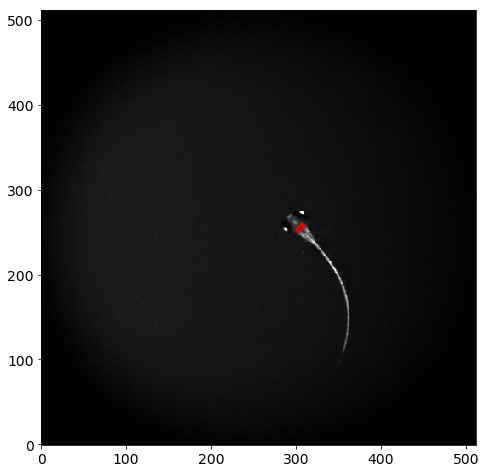

In [351]:
fig, axs = plt.subplots(figsize=(8,8))
axs.imshow(fish_ims_raw[t], cmap='gray', clim=clim, origin='lower')    
ori = tx['brain_centers'][t][::-1]
rect = affine_rect(ori, x.stop-x.start, y.stop-y.start, , axis=axs, color='r', linewidth=2, fill=False)
axs.add_patch(rect)

In [ ]:
example_fish = '6dpf_cy221xcy221_f2_spon_1'
fish_ims_al = pims.open(str(exps[example_fish]['aligned']))
fish_ims_raw = pims.ImageSequence(sorted(exps[example_fish]['raw_dir'].glob('*.tif')))
brain_pos = np.load(exps[example_fish]['pos_params'])['brain_centers']
affines = np.load(exps[example_fish]['affine_params_fname'])

fish_ind = 0

In [ ]:
# Make sequence of images showing struggle and fluorescence
# use 6dpf_cy221xcy221_f2_spon_1_aligned.tif

from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch, Rectangle
import matplotlib as mpl
label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 18,
        }

example_fish = 0
fish_ims_al = aligned_ims[example_fish]
fish_ims_raw = raw_ims[example_fish]
tx = pos_params[example_fish]
tpoints = (13838, 14130, 14422)
colors = {'fl_ts':'g', 'tail_ts':'c'}
roi = {}
roi['brain'] = (slice(min(tpoints)- 2000, max(tpoints) + 2000), slice(94, 104), slice(190, 194))
#roi['spine'] = (slice(min(tpoints)- 2000, max(tpoints) + 2000), slice(94, 108), slice(160, 164))
x_axis = (np.arange(roi['brain'][0].start, roi['brain'][0].stop)) / fs_im

crop = 10
fig = plt.figure(figsize=(16,8))
gs = GridSpec(nrows=3, ncols=3, height_ratios=(4,1,1))
axs_ims = []

# set the clim based on the brain fluorescence, not the eyes
# x position before eyes appear in image
eye_cutoff = 200
clim = min([fish_ims_al[t][crop:-crop, crop:-crop].min() for t in tpoints]), max([fish_ims_al[t][crop:-crop, crop:eye_cutoff].max() for t in tpoints])

# show fish images
for ind, t in enumerate(tpoints):
    axs_ims.append(fig.add_subplot(gs[0,ind]))
    axs_ims[-1].imshow(fish_ims_raw[t], cmap='gray', clim=clim, origin='lower')    
    axs_ims[-1].axis('off')
    for key, val in roi.items():
        patch = Rectangle((val[2].start, val[1].start), 
                 val[2].stop - val[2].start, 
                 val[1].stop - val[1].start, fill=False, color='r', linestyle='-', linewidth=2)
        # don't add the patch until I can properly orient it relative to the moving fish brain
        #axs_ims[-1].add_patch(patch)

axs_ts = []
axs_ts.append(fig.add_subplot(gs[1,:]))
axs_ts.append(fig.add_subplot(gs[2,:]))
axs_ts[1].plot(x_axis, np.array(fish_ims_al[roi['brain'][0]])[:,roi['brain'][1],roi['brain'][2]].mean((1,2)), color=colors['fl_ts'])

# Draw dotted lines for the sampled timepoints
for ind, t in enumerate(tpoints):
    xyA = (t/fs_im, axs_ts[1].get_ylim()[0])
    xyB = (t/fs_im, axs_ts[0].get_ylim()[-1])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axs_ts[1], axesB=axs_ts[0],shrinkB=0,color='grey', linestyle='--', alpha=.7, linewidth=3)

    axs_ts[1].add_artist(con)

axs_ts[1].set_ylabel('ROI Intensity \n (a.u.)', fontdict=font)
axs_ts[1].set_xlabel('Time (s)', fontdict=font)

axs_ts[0].plot(x_axis, tail_angles[example_fish][0][roi['brain'][0]], alpha=.8, color=colors['tail_ts'])
axs_ts[0].set_ylabel('Tail angle \n (radians)', fontdict=font)

axs_format(axs_ts[1])
axs_format(axs_ts[0])
axs_ts[0].spines['bottom'].set_visible(False)

# erase x-axis for top timeseries plot
axs_ts[0].tick_params(
    axis='x',         
    which='both',     
    bottom='off',     
    top='off',        
    labelbottom='off')

# Stick connecting lines between images and timeseries
for ind, t in enumerate(tpoints):
    xyA = (.5,0)
    xyB = (t/fs_im, axs_ts[0].get_ylim()[-1])
    coordsA = "axes fraction"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axs_ims[ind], axesB=axs_ts[0],
                      arrowstyle="->", shrinkB=10)

    axs_ims[ind].add_artist(con)

axs_ts[0].annotate('Tail Angle', (.15,.65), xycoords='axes fraction',color=colors['tail_ts'], fontsize=label_size)
axs_ts[1].annotate('$\itgfap$:GCaMP6f fluorescence', (.15,.65), xycoords='axes fraction',color=colors['fl_ts'], fontsize=label_size)

#plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/embedding_video_struggle_example.pdf')

In [189]:
fluo_ims = np.array(ims[exp])
fs_im = 100

# skip the first minute of the recording
roi = (slice(fish_onsets[exp], None), slice(90,108), slice(190,194))
t = np.arange(fluo_ims.shape[0])[roi[0]] / fs_im
fluo_ts_raw = fluo_ims[roi].mean((1,2))
fluo_ts_dff = dff(fluo_ts_raw, window = fs_im * 20, percentile=10, baseline_offset=.1, downsample=8)
fluo_ts_filt = median_filter(fluo_ts_dff, size=1 * fs_im)

#beh_ts = fs_im * np.diff(tail_angle(fluo_ims[roi[0]], (100,200), 90)[0])
beh_ts = tail_angle(fluo_ims[roi[0]], (100,200), 130)[0]
fig, axs = plt.subplots(nrows=2, figsize=(12,8))
ax_beh = axs[0]
ax_beh.plot(t[1:], np.diff(beh_ts), color='m')
ax_beh.set_ylabel('Radians / s')
ax_fluo = ax_beh.twinx()
ax_fluo.plot(t, fluo_ts_dff, linewidth=2, color='g', alpha=.7, zorder=0)
ax_fluo.plot(t, fluo_ts_filt, linewidth=2, color='g', alpha=.7, zorder=0)
ax_fluo.set_ylabel('Baseline-normalized fluorescence [dff]')
axs[0].legend([ax_beh.lines[-1], ax_fluo.lines[-1]], ['Angular tail velocity','Smoothed fluorescence'], )

axs[0].set_xlabel('Time [s]')

from matplotlib.patches import Rectangle
from skimage.exposure import adjust_gamma
axs[1].imshow(adjust_gamma(fluo_ims[roi[0]].mean(0), .1), cmap='gray', origin='lower')
rect = Rectangle((roi[2].start, roi[1].start), roi[2].stop - roi[2].start, roi[1].stop - roi[1].start, fill=False, color='r')
axs[1].add_patch(rect)
axs[1].set_xlim(150,229)

axs[1].set_ylim(80,120)
#plt.savefig(fnames[cur_exp].split('.')[0] + '_summary.pdf')

NameError: name 'ims' is not defined